#### Version - 1.0
### Introduction: Methodology

This analysis aims to develop an interpretable and stable model for predicting customer churn in the Telco dataset. The methodology is structured around simplified feature engineering, model building, and a data-driven approach to feature selection.

**Base Hypotheses:**

1.  One-hot encoded features improve model stability.
2.  Selecting the k most linearly correlated features enables effective and stable model construction.


### 1. Data Loading and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\91807\Desktop\Project\Customer_churn_telco\data\Telco_customer_churn.csv")
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Function: preprocess_telco_data

This function preprocesses the Telco customer churn dataset by performing the following operations:
1. Converting TotalCharges to numeric and handling missing values.
2. Converting SeniorCitizen to boolean.
3. Removing the customerID column.

Justification:
1. TotalCharges: The 'TotalCharges' column was initially loaded as an object
    (string) type, but it represents numerical data. This function converts
    it to a numeric type (float). Missing values in 'TotalCharges' are
    handled by dropping rows where 'tenure' is zero. This is done because
    the missing 'TotalCharges' values correspond to customers with zero
    tenure, suggesting that they have not yet incurred any charges.
    Dropping these rows is a safer approach than imputing values, as it
    avoids introducing potentially incorrect assumptions into the data.

2. SeniorCitizen: The 'SeniorCitizen' column, representing whether a
    customer is a senior citizen, was initially loaded as a numerical type
    (0 or 1). This function converts it to a boolean type (True or False)
    for better semantic clarity and consistency with other boolean columns.

3. customerID: The 'customerID' column is a unique identifier for each
    customer and does not provide any predictive information for churn.
    Therefore, it is removed from the DataFrame to reduce dimensionality
    and improve model performance.


In [ ]:
def preprocess_telco_data_1(df):
    """
    Preprocesses the Telco customer churn dataset by:
    1. Converting TotalCharges to numeric and handling missing values.
    2. Converting SeniorCitizen to boolean.
    3. Removing the customerID column.

    Args:
        df (pd.DataFrame): The raw Telco customer churn dataset.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """

    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")
    zero_tenure = df[df['tenure'] == 0].index
    na_total_charges = df[df['TotalCharges'].isnull()].index
    if zero_tenure.equals(na_total_charges): #check the equality before dropping.
        df = df.drop(index=zero_tenure)

    df['SeniorCitizen'] = (df['SeniorCitizen']).astype(bool)
    df = df.drop(columns=['customerID'])

    return df

In [7]:
df_processed = preprocess_telco_data_1(df)
df_processed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,False,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,False,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,False,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,False,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,False,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Function: 
- (a) convert_yes_no_to_boolean
- (b) get_yes_no_columns

These functions convert columns with 'Yes'/'No' values to boolean True/False in a Pandas DataFrame.

Justification:
1. Ensures that Yes'es and No's are not one-hot encoded.
2. Converts Object type to boolean

In [ ]:
def convert_yes_no_to_boolean(df, columns):
    """
    Converts 'Yes'/'No' columns to boolean True/False.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns.
        columns (list): A list of column names with 'Yes'/'No' values.

    Returns:
        pd.DataFrame: The DataFrame with converted boolean columns.
    """
    df_converted = df.copy()  # Create a copy to avoid modifying the original

    for col in columns:
        if col in df_converted.columns:
            df_converted[col] = df_converted[col].map({'Yes': True, 'No': False})

    return df_converted


def get_yes_no_columns(df):
    """
    Automatically identifies columns in a DataFrame that contain only 'Yes' and 'No' values.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        list: A list of column names containing only 'Yes' and 'No' values.
    """

    yes_no_cols = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {'Yes', 'No'}:
            yes_no_cols.append(col)
    return yes_no_cols


['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']


In [10]:
bool_cols = get_yes_no_columns(df_processed)
df_encoded = convert_yes_no_to_boolean(df_processed, bool_cols)
df_encoded.head(5).T

,0,1,2,3,4
gender,Female,Male,Male,Male,Female
SeniorCitizen,False,False,False,False,False
Partner,True,False,False,False,False
Dependents,False,False,False,False,False
tenure,1,34,2,45,2
PhoneService,False,True,True,False,True
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No
OnlineBackup,Yes,No,Yes,No,No


In [13]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   bool   
 2   Partner           7032 non-null   bool   
 3   Dependents        7032 non-null   bool   
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   bool   
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   bool   
 16  PaymentMethod     7032 non-null   object 
 17  

#### Function: convert_remaining_objects_to_dummies

This function converts the remaining object type columns in a Pandas DataFrame to dummy variables using one-hot encoding.

Justification:
1. Listed in the base hypothesis. 

In [64]:
def convert_remaining_objects_to_dummies(df, exclude_columns=None):
    """
    Converts remaining object type columns in a DataFrame to dummy variables
    using one-hot encoding, and converts boolean columns to 0/1.

    Args:
        df (pd.DataFrame): The input DataFrame.
        exclude_columns (list, optional): A list of column names to exclude from
                                          dummy variable conversion. Defaults to None.

    Returns:
        pd.DataFrame: A new DataFrame with object type columns converted to
                      dummy variables and boolean columns converted to 0/1.
    """

    df_dummies = df.copy()  # Create a copy to avoid modifying the original
    object_cols = df_dummies.select_dtypes(include=['object']).columns

    if exclude_columns:
        object_cols = [col for col in object_cols if col not in exclude_columns]

    df_dummies = pd.get_dummies(df_dummies, columns=object_cols, drop_first=True)

    # Convert boolean columns to 0/1
    bool_cols = df_dummies.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df_dummies[col] = df_dummies[col].astype(int)

    return df_dummies

In [65]:
df_encoded = convert_remaining_objects_to_dummies(df_encoded, None)
df_encoded.head(5).T

,0,1,2,3,4
SeniorCitizen,0.00,0.00,0.00,0.00,0.00
Partner,1.00,0.00,0.00,0.00,0.00
Dependents,0.00,0.00,0.00,0.00,0.00
tenure,1.00,34.00,2.00,45.00,2.00
PhoneService,0.00,1.00,1.00,0.00,1.00
PaperlessBilling,1.00,0.00,1.00,0.00,1.00
MonthlyCharges,29.85,56.95,53.85,42.30,70.70
TotalCharges,29.85,1889.50,108.15,1840.75,151.65
Churn,0.00,0.00,1.00,0.00,1.00
gender_Male,0.00,1.00,1.00,1.00,0.00


#### Correlation Testing

In [66]:
corr_matrix = df_encoded.corr()
churn_corr = corr_matrix['Churn']

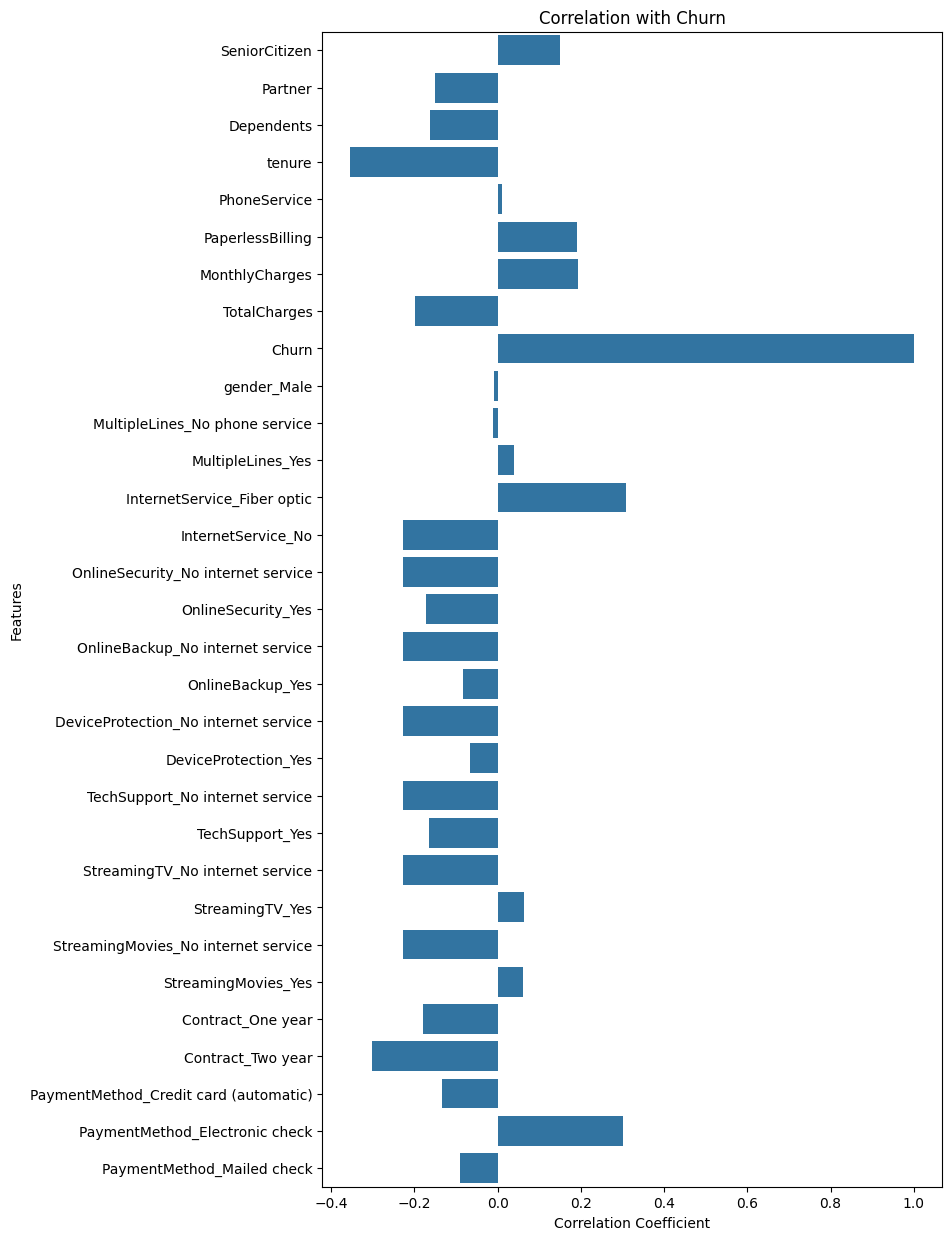

In [67]:
plt.figure(figsize=(8,15))
sns.barplot(x=churn_corr.values, y=churn_corr.index)
plt.title('Correlation with Churn')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')
plt.show()


In [68]:
threshold = 0.3
lst = []

for i, j in churn_corr.items():
    if abs(j) > threshold:
        lst.append(i)
        
display(lst, len(lst))

['tenure',
 'Churn',
 'InternetService_Fiber optic',
 'Contract_Two year',
 'PaymentMethod_Electronic check']

5

- We have 5 features (directly) with a corr. of above 0.3
- This is a lackluster way to go about this ( I KNOW!!! ) but this is the first approach to build a model. 
- Lets select these highly correlated features (manually, cause i didnt think it through fully)

In [69]:
df_processed.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [70]:
columns_to_keep = ['Churn', 'tenure', 'InternetService', 'Contract', 'PaymentMethod']
columns_to_remove = [x for x in df_processed.columns if x not in columns_to_keep]
columns_to_remove

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges']

In [71]:
df_final = df_processed.drop(columns=columns_to_remove)
df_final.head(5).T

,0,1,2,3,4
tenure,1,34,2,45,2
InternetService,DSL,DSL,DSL,DSL,Fiber optic
Contract,Month-to-month,One year,Month-to-month,One year,Month-to-month
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check
Churn,No,No,Yes,No,Yes


In [72]:
bool_cols = get_yes_no_columns(df_final)

if bool_cols:
    df_final = convert_yes_no_to_boolean(df_final, bool_cols)

df_final_encoded = convert_remaining_objects_to_dummies(df_final)
df_final_encoded.head(5).T

,0,1,2,3,4
tenure,1,34,2,45,2
Churn,0,0,1,0,1
InternetService_Fiber optic,0,0,0,0,1
InternetService_No,0,0,0,0,0
Contract_One year,0,1,0,1,0
Contract_Two year,0,0,0,0,0
PaymentMethod_Credit card (automatic),0,0,0,0,0
PaymentMethod_Electronic check,1,0,0,0,1
PaymentMethod_Mailed check,0,1,1,0,0


In [73]:
from sklearn.model_selection import train_test_split

In [74]:
def split_data(df, target_column='Churn', test_size=0.2, val_size=0.2, random_state=42):
    """
    Splits a DataFrame into training, validation, and test sets.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_column (str, optional): The name of the target variable column. Defaults to 'Churn'.
        test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
        val_size (float, optional): The proportion of the *remaining* data (after test split) to include in the validation split. Defaults to 0.2.
        random_state (int, optional): Controls the shuffling applied to the data before applying the split. Defaults to 42.

    Returns:
        tuple: A tuple containing four DataFrames: (X_train, X_val, X_test, y_train, y_val, y_test)
    """

    # Separate features (X) and target (y)
    y = df[target_column]
    X = df.drop(target_column, axis=1)

    # Split into train and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Split train_val into train and validation sets
    remaining_val_size = val_size / (1 - test_size) #adjust the validation size based on the first split.
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=remaining_val_size, random_state=random_state, stratify=y_train_val)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [75]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_final_encoded)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4218, 8)
X_val shape: (1407, 8)
X_test shape: (1407, 8)
y_train shape: (4218,)
y_val shape: (1407,)
y_test shape: (1407,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(solver='liblinear', random_state=42)  # Use liblinear for smaller datasets
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

print("Validation Accuracy:", accuracy)
print("Classification Report:\n", report)

Validation Accuracy: 0.7818052594171997
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.44      0.52       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.69      1407
weighted avg       0.77      0.78      0.77      1407



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)  

y_val_pred_rf = rf_model.predict(X_val)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
report_rf = classification_report(y_val, y_val_pred_rf)
auc_roc_rf = roc_auc_score(y_val, rf_model.predict_proba(X_val)[:, 1]) 

print("Validation Accuracy (Random Forest):", accuracy_rf)
print("Classification Report (Random Forest):\n", report_rf)
print("AUC-ROC (Random Forest):", auc_roc_rf)

Validation Accuracy (Random Forest): 0.759772565742715
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1033
           1       0.55      0.49      0.52       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.75      0.76      0.76      1407

AUC-ROC (Random Forest): 0.7757129693380476


#### Model Comparison: Churn Prediction

**Logistic Regression (Without SMOTE):**

* **Validation Accuracy:** 0.7818
* **Churn (Class 1) Performance:**
    * Precision: 0.63
    * Recall: 0.44
    * F1-score: 0.52
* **Key Finding:** Performs better on non-churners; struggles to identify churners.

**Random Forest (Without SMOTE):**

* **Validation Accuracy:** 0.7598
* **Churn (Class 1) Performance:**
    * Precision: 0.55
    * Recall: 0.49
    * F1-score: 0.52
* **AUC-ROC:** 0.7757
* **Key Finding:** Similar to Logistic Regression, struggles with churn prediction due to class imbalance.

#### Using Smote To deal with the imbalance

In [87]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)  # Initialize SMOTE

# Apply SMOTE to the training data ONLY
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [91]:
lr_model_smote = LogisticRegression(solver='liblinear', random_state=42)
lr_model_smote.fit(X_train_smote, y_train_smote)

y_val_pred_smote = lr_model_smote.predict(X_val)

accuracy_lr_smote = accuracy_score(y_val, y_val_pred_smote)
report_lr_smote = classification_report(y_val, y_val_pred_smote)

print("Validation Accuracy:", accuracy_lr_smote)
print("Classification Report:\n", report_lr_smote)

Validation Accuracy: 0.728500355366027
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.79      1033
           1       0.49      0.76      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [92]:
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

y_val_pred_rf_smote = rf_model_smote.predict(X_val)

accuracy_rf_smote = accuracy_score(y_val, y_val_pred_rf_smote)
report_rf_smote = classification_report(y_val, y_val_pred_rf_smote)
auc_roc_rf_smote = roc_auc_score(y_val, rf_model_smote.predict_proba(X_val)[:, 1])

print("Validation Accuracy:", accuracy_rf_smote)
print("Classification Report:\n", report_rf_smote)
print("AUC-ROC:", auc_roc_rf_smote)

Validation Accuracy: 0.7256574271499645
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.74      0.80      1033
           1       0.49      0.70      0.57       374

    accuracy                           0.73      1407
   macro avg       0.68      0.72      0.69      1407
weighted avg       0.77      0.73      0.74      1407

AUC-ROC: 0.7806334801807726


#### Random Forest with SMOTE vs. Logistic Regression with SMOTE: Performance Summary

**Random Forest (with SMOTE):**

* **Validation Accuracy:** 0.7257
* **Churn (Class 1) Performance:**
    * Precision: 0.49
    * Recall: 0.70
    * F1-score: 0.57
* **AUC-ROC:** 0.7806
* **Key Finding:** Moderate accuracy, improved recall for churners, but precision remains low.

**Logistic Regression (with SMOTE):**

* **Validation Accuracy:** 0.7285
* **Churn (Class 1) Performance:**
    * Precision: 0.49
    * Recall: 0.76
    * F1-score: 0.60
* **Key Finding:** Similar accuracy to Random Forest, slightly higher recall and F1-score for churners, but precision is also low.

**Comparative Analysis:**

* Both models, when using SMOTE, demonstrate a similar validation accuracy around 72-73%.
* Logistic Regression exhibits a slightly better ability to recall churned customers (higher recall) and a better f1 score for the churn class.
* Both models suffer from low precision in predicting churn, indicating that when they predict a customer will churn, they are often incorrect.
* The AUC-ROC scores are comparable, suggesting similar overall ability to distinguish between churners and non-churners.
* SMOTE improves recall for the churn class in both models, which is often a priority in churn prediction. However, it comes at the cost of lower precision.

<hr>

## Churn Prediction Model Summary: Inadequate Performance

**Findings:**

* Both Logistic Regression and Random Forest models, with and without SMOTE, exhibit limitations in accurately predicting customer churn.
* While SMOTE improved recall (identifying churners), it significantly reduced precision (increased false positives).
* Overall accuracy varied, but the models consistently struggled to balance precision and recall, particularly for the churn class.
* The models showed similar performance when SMOTE was applied, indicating potential limitations in the current feature set or model complexity.

**Conclusion:**

The current models, despite attempts to address class imbalance with SMOTE, are **inadequate for reliable churn prediction**. Their simple approach and limited performance necessitate exploring more advanced techniques.

In [102]:
import pickle 

with open(r'..\models\v1.0_lr_model_smote.pkl', 'wb') as f:
    pickle.dump(lr_model_smote, f)

In [ ]:
with open(r'..\models\v1.0_lr_model_smote.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")

Model loaded successfully.
